Code mostly taken from this [example notebook](https://github.com/facebook/prophet/blob/main/notebooks/quick_start.ipynb) on Prophet's github.

In [ ]:
!pip install prophet

     |████████████████████████████████| 65 kB 3.1 MB/s 
     |████████████████████████████████| 49 kB 3.0 MB/s 
     |████████████████████████████████| 45 kB 390 kB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6639136 sha256=c48dbe9560c58cd687ee65e0d17d3a6bcdded253e73446c1aa65be07e18eb9f2
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [ ]:
import pandas as pd
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

Import vaccine data (copied from Michael's code)

In [ ]:
vax_raw = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv")

# list of countries with continents I found online
countries = pd.read_csv("https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv")


# process data
# the vax data does not have continent information, so I had to add it
# the data also has aggregated data for africa itself (as well as other continents or groups like the EU)
countries = countries[["alpha-3", "region"]]
africa_row = ["OWID_AFR", "Africa"]
countries.loc[len(countries)] = africa_row # add country code for Africa
vax = vax_raw.merge(right=countries, left_on="iso_code", right_on="alpha-3") # add continent info for vax data
vax["date"] = pd.to_datetime(vax["date"])

# get only africa data, should be 54 countries + 1 aggregated
africa = vax[vax["region"] == "Africa"][["location", "date", "people_fully_vaccinated_per_hundred"]]
len(africa["location"].unique())

55

## Fitting deltas over Africa

In [ ]:
africa

,location,date,people_fully_vaccinated_per_hundred
421,Africa,2021-01-09,NaN
422,Africa,2021-01-10,NaN
423,Africa,2021-01-11,NaN
424,Africa,2021-01-12,NaN
425,Africa,2021-01-13,NaN
...,...,...,...
89059,Zimbabwe,2022-04-19,24.00
89060,Zimbabwe,2022-04-20,NaN
89061,Zimbabwe,2022-04-21,24.01
89062,Zimbabwe,2022-04-22,24.05


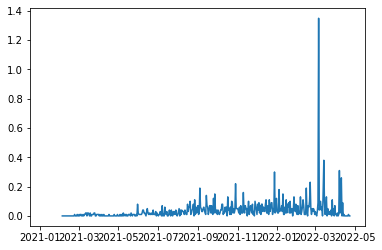

In [ ]:
a = africa[africa["location"] == "Africa"].reset_index()
delta = np.diff(a['people_fully_vaccinated_per_hundred'])
a["delta"] = 0
a.loc[1:, "delta"] = delta
plt.plot(a["date"], a["delta"])

In [ ]:
a_fit = a[["date", "people_fully_vaccinated_per_hundred"]].rename(columns = {"date": "ds", "people_fully_vaccinated_per_hundred": "y"})
m = Prophet()
m.fit(a_fit)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


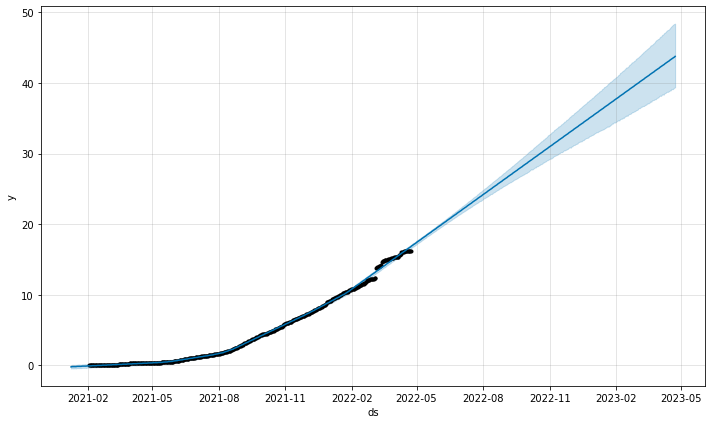

In [ ]:
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
plots = m.plot(forecast)

In [ ]:
trends = forecast[["ds", "yhat_lower", "yhat_upper", "yhat"]]
#trends["means"] = np.cumsum(np.append([0], trends["yhat"]))
trends.loc[:,"means"] = np.cumsum(trends["yhat"])
trends.loc[:,"low"] = np.cumsum(trends["yhat_lower"])
trends.loc[:,"high"] = np.cumsum(trends["yhat_upper"])
trends

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,ds,yhat_lower,yhat_upper,yhat,means,low,high
0,2021-01-09,-0.433312,0.046601,-0.197210,-0.197210,-0.433312,0.046601
1,2021-01-10,-0.398237,0.080952,-0.164772,-0.361981,-0.831549,0.127553
2,2021-01-11,-0.406170,0.101702,-0.157979,-0.519960,-1.237719,0.229255
3,2021-01-12,-0.415509,0.090527,-0.154978,-0.674938,-1.653228,0.319782
4,2021-01-13,-0.407833,0.088688,-0.158893,-0.833831,-2.061061,0.408470
...,...,...,...,...,...,...,...
830,2023-04-19,39.133791,48.142228,43.471410,13213.266362,12433.478407,13992.117006
831,2023-04-20,39.135649,48.234151,43.542589,13256.808951,12472.614057,14040.351157
832,2023-04-21,39.271791,48.328423,43.609786,13300.418737,12511.885848,14088.679580
833,2023-04-22,39.359347,48.378468,43.674290,13344.093027,12551.245194,14137.058048


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=trends.ds, y=trends.yhat,
                    mode='lines',
                    line_color='rgb(0,176,246)',
                    name='lines'))
fig.add_trace(go.Scatter(
        x=trends.ds,
        y=trends.yhat_upper,
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False
    ))

fig.add_trace(go.Scatter(
        x=trends.ds,
        y=trends.yhat_lower,
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty',
        showlegend=False
    ))

fig.show()

Trial run of Prophet just for data on Zimbabwe:

In [ ]:
# need to rename columns as "ds" and "y" in order to pass into Prophet
zimbabwe = africa[africa['location'] == 'Zimbabwe'][["date", "people_vaccinated_per_hundred"]].rename(columns={"date": "ds", 
                                                                                                               "people_vaccinated_per_hundred": "y"} )
zimbabwe.tail()

,ds,y
89059,2022-04-19,38.49
89060,2022-04-20,NaN
89061,2022-04-21,38.55
89062,2022-04-22,38.58
89063,2022-04-23,38.62


In [ ]:
m = Prophet()
m.fit(zimbabwe)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
774,2023-04-03
775,2023-04-04
776,2023-04-05
777,2023-04-06
778,2023-04-07


In [ ]:
forecast = m.predict(future)
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

,ds,yhat,yhat_lower,yhat_upper
774,2023-04-03,55.316081,32.712427,76.683459
775,2023-04-04,55.412377,32.545651,76.227120
776,2023-04-05,55.541804,33.029413,76.772735
777,2023-04-06,55.613592,32.666276,76.685796
778,2023-04-07,55.648850,32.493868,76.598777


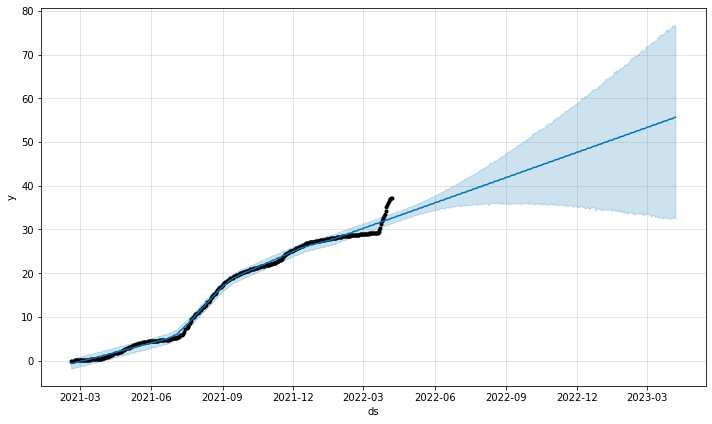

In [ ]:
fig1 = m.plot(forecast)

Hmm ok, this doesn't look so good. Maybe better if we try with other countries? Will try a few others tomorrow and see what happens. Prophet is supposed to work well with daily observations that have at least a year of history, though.